# Intermediate notebook 2: stellar rotation rates
Stars rotate. This feature is inherently linked to stellar formation — the molecular clouds from which stars form need only very slightly rotate, and conservation of angular momentum makes sure that the final, formed star rotates, as well.

The rotation rate of a stars tel us about their evolution, their magnetic fields, etc. Stellar light curves (time-series photometry) offer a glimpse into the rotation rates of these bodies. The core idea is that stars are not homogeneous; rather, they can have cooler spots on their surface that rotate in and out of view. The classical picture is of a large single spot that yields a sinusoidal light curve, as an observer detects fewer photons when the spot is in view. In reality, stars are not so ideal — they may have multiple spots at once, and these spots evolve over time. But the general idea remains: the periodicity of a light curve is related to its rotation rate.

In this notebook, we will work through the key mechanics of identifying a star’s rotation period from its TESS light curve. We will then apply this to a large population of stars to understand how rotation rates vary across the M dwarf population.

AS: still reference flare notebook here? I wrote it as a prerequisite somewhere.

# Learning objectives
- Extract a stellar rotation rate from a TESS light curve using lightkurve
- Apply the Nyquist-Shannon Samping Theorem when finding stellar rotation rates by restricting periodogram searches

# Arjun to-do
- check whether flares people do any other processing.
- address Julia and Thomas comments
- remove all notes to self
- Make solutions notebook

# Prerequisites
- Familiarity with writing functions: https://www.py4e.com/html3/04-functions
- Previous TIKE notebook: [Classifying stellar flares with stella](../../05-classify-with-ml)

## Import Statements

* **numpy** is used for array manipulation.

* **matplotlib.pyplot** is used to display images and plot datasets.
* **lightkurve** allows us to easily interact with TESS light curves.


In [105]:
# manipulating and plotting arrays
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker

# file handling
import tarfile
from tqdm import tqdm
from astropy.io import fits
from astropy.utils.data import download_file
from lightkurve.search import search_lightcurve

# machine learning packages

import keras
from keras.models import Sequential, Model, load_model
from keras.layers import Input, Flatten, Dense, Activation, Dropout, BatchNormalization
from keras.layers.convolutional import Convolution1D, MaxPooling1D
from sklearn import metrics



#setting random seeds
seed = 42
np.random.seed(seed)
import os
os.environ['PYTHONHASHSEED']=str(seed)
import random
random.seed(seed)
import tensorflow as tf
tf.random.set_seed(seed)

%matplotlib inline

In [3]:
conda run pip install git+https://github.com/afeinstein20/stella

  Cloning https://github.com/afeinstein20/stella to /tmp/pip-req-build-1i41qczx
  Resolved https://github.com/afeinstein20/stella to commit f9ffd78d1c7279012e870f3657812595f18eee74
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'

  Running command git clone --filter=blob:none --quiet https://github.com/afeinstein20/stella /tmp/pip-req-build-1i41qczx


Note: you may need to restart the kernel to use updated packages.


In [4]:
import stella

In [5]:
# ticids = ['278779899', '139754153', '273418879', '52121469', '188580272', '394015919', '402104884']
ticids = ['234295610']


# for all the selected targets, pull the available lightcurves using the lightkurve package
sectors = [1, 2] # only consider the first few sectors
lcs = []
for name in ticids:
    lc = search_lightcurve(target='TIC'+name, mission='TESS', sector=sectors, author='SPOC')
    lc = lc.download_all()[0]

<AxesSubplot:xlabel='Time - 2457000 [BTJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

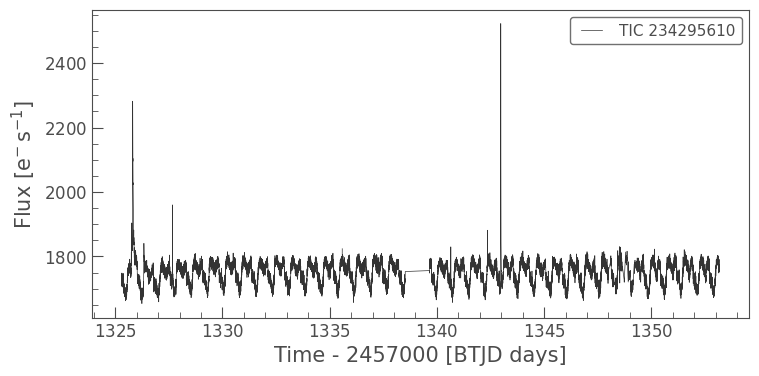

In [6]:
lc.plot()

This light curve is quite interesting. There's definitely at least one source of periodicity (the regularly spaced wiggles in the graph), and there are a few regions of high flux. Might they be flares? We'll return to this question later on by explicitly comparing these features with stellar flare classifiers.

To address the first bit—finding periodicity in the data—we need to calculate a *periodogram*. A periodogram is a mathematical estimate of how strong different periods are in a dataset. Under the hood, most periodograms are fundamentally related to <a href="https://news.mit.edu/2009/explained-fourier">Fourier Transforms</a>. 

Before we call the periodogram, we want to consider what a maximum period of the pulsations might be. Based on some science cases, we might be interested in stellar periodicity that is quite long. Betelgeuse, for instance, is a star that <a href="https://arxiv.org/abs/2306.00287">has quite interesting pulsations</a> on the order of 2200 days. However, we're fundamentally limited by our observing strategy based on something called the Nyquist-Shannon Theorem.

AS:
- talk about the harmonics.
- stitch together multiple sectors.

## Relevance of the Nyquist-Shannon Sampling Theorem
The <a href="https://chem.libretexts.org/Ancillary_Materials/Laboratory_Experiments/Wet_Lab_Experiments/Analytical_Chemistry_Labs/ASDL_Labware/Analog_and_Digital_Conversion_for_Chemical_Instrumentation/04_Number_Representation/05_The_Nyquist_Sampling_Theorem">Nyquist theorem</a> is a fundamental aspect of signal processing. Essentially, it implies that we cannot search for periodicity that is more than half of an observational baseline. The basic intuition is as follows: for a sine wave, our data would need to at least contain the wave hit both its peak and its trough for us to understand its period. For more information, see [VanderPlas 2018](https://iopscience.iop.org/article/10.3847/1538-4365/aab766#apjsaab766s3), especially section 3.2.1. 

This idea has direct application to our science goals. TESS observes stars in 28-day baselines (aside from those in the continuous viewing zone); therefore, for most stars that TESS observes, we can only search for periods of at most 14 days. Let's implement this in code.

In [7]:
(lc.time.max() - lc.time.min()).value

27.88060651831097

In [8]:
lc_interval = (lc.time.max() - lc.time.min()).value

max_period = lc_interval/2

Now that we've set the maximum period, we'll also want to set the minimum_period. Let's set that to the TESS sampling rate: 20 seconds.

In [20]:
min_period = 1 / 24 / 60 / 60 * 20

In [21]:
pg = lc.normalize(unit='ppm').to_periodogram(maximum_period=max_period, minimum_period=min_period)

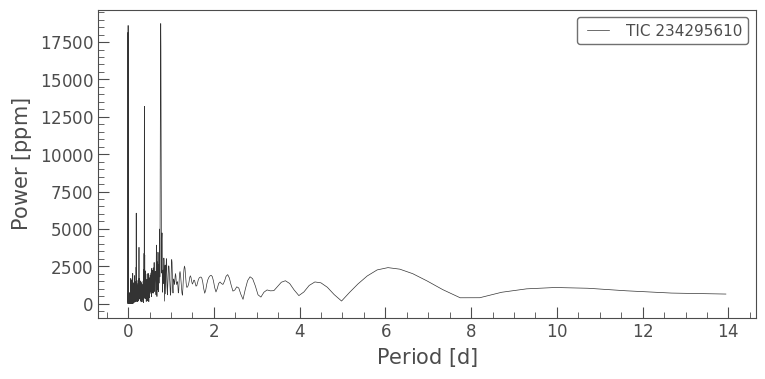

In [22]:
pg.plot();

We see some strong peaks already in just this single light curve. We haven't even performed any real processing yet!

We can print out the "best" period (the one corresponding to the strongest periodogram peak) with the below command:

AS: explain the power ppm units better?

In [23]:
pg.period_at_max_power

<Quantity 0.76176521 d>

 Let's plot this periodogram on a log scale. What do we see? (Describe why there's more noise at the low-frequency end of things. Can we assign "proper" bins?)

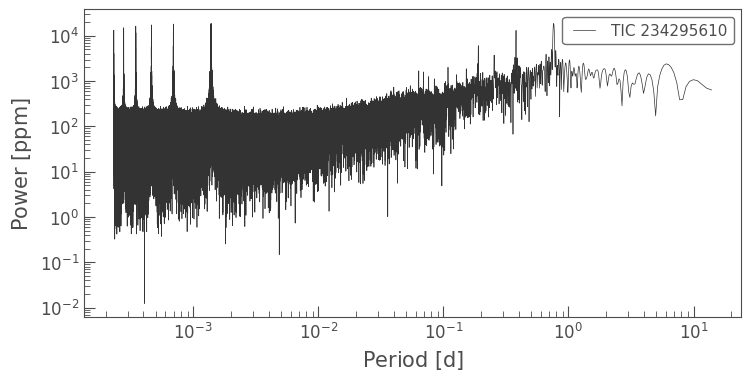

In [24]:
pg.plot(scale='log');

It seems like there are some very short-period peaks in the periodogram. Might they be the stellar rotation rate?

Probably not. We expect the rotation rate of of low-mass stars to be on the order of days to tens of days (e.g., <a href="https://adsabs.harvard.edu/full/record/seri/ApJ../0466/1996ApJ...466..384D.html">Donahue et al. 1996</a>). These shorter-period frequencies may be stellar oscillations or pulsations, or harmonic aliases of a single oscillation/pulsation mode. (AS: this is technical. I will break this down a bit).

We can rule these out as stellar rotation rates that would imply that the star is rotating at twice the breakup speed of a main-sequence star. Let's first calculate the break-up rotational period of the Sun.

In [32]:
import astropy.constants as const
import astropy.units as u

In [45]:
G = const.G
M = 1 * u.M_sun
R = 1 * u.R_sun
vc = ((2/3) * G * M / R)**.5

P = 2 * np.pi * R  / vc

In [47]:
P.to(u.day)

<Quantity 0.14186947 d>

Let's generously assume that a star in our sample could rotate 100 times faster than this without breaking up. This sets a new minimum period that's longer than our sampling rate.

In [51]:
min_period = P.to(u.day).value/100

In [55]:
pg = lc.normalize(unit='ppm').to_periodogram(maximum_period=max_period, minimum_period=min_period)

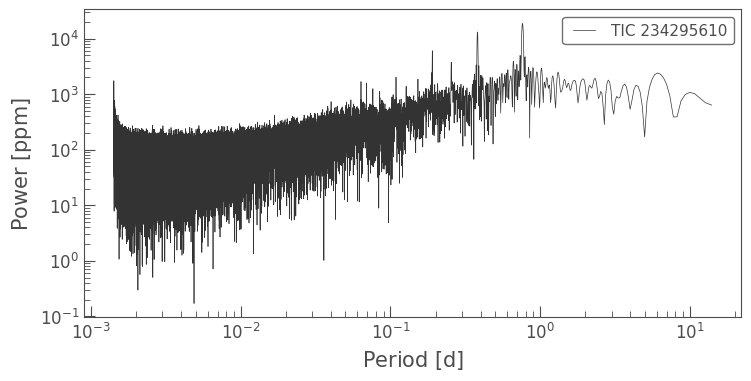

In [56]:
pg.plot(scale='log');

Cool! It looks like our strongest signal is now clearly the peak just shy of 1 day.

Next, let's consider what might happen to this periodogram if we consider "standard" data-cleaning practices for light curves. For instance, we can perform outlier rejection, removing points from the lightcurve if they stray too far (as specified by a number of datndard deviations) from the mean. `lightkurve` provides a clear method for removing outliers in its lightcurves.

<AxesSubplot:xlabel='Period [$\\mathrm{d}$]', ylabel='Power [$\\mathrm{ppm}$]'>

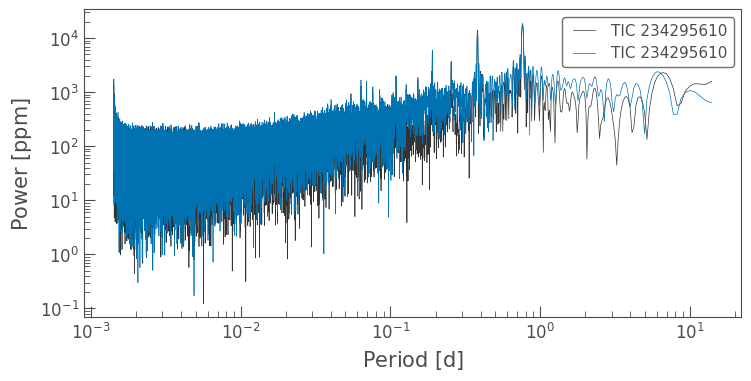

In [57]:
lc_clipped = lc.remove_outliers(sigma=3)

pg_clipped = lc_clipped.normalize(unit='ppm').to_periodogram(maximum_period=max_period, minimum_period=min_period)
ax = pg_clipped.plot(scale='log', zorder=1);

pg.plot(ax=ax, scale='log')

If we change this to just the 1-sigma outliers, the periodicity we're looking for is removed entirely. This is, in short, not good. The implication is that when cleaning our datasets, we should take care to not clean them so much that the signal of interest is removed.

<AxesSubplot:xlabel='Period [$\\mathrm{d}$]', ylabel='Power [$\\mathrm{ppm}$]'>

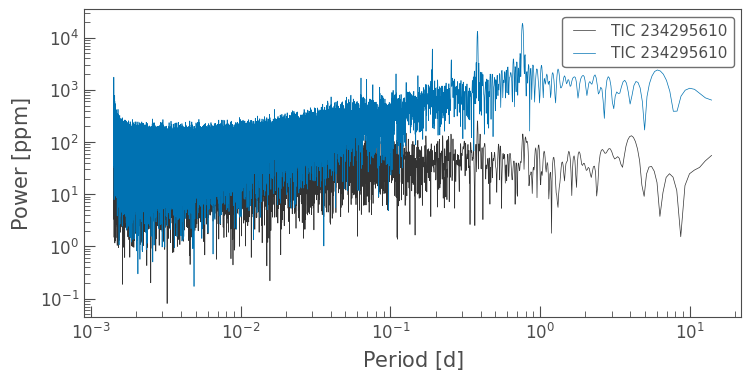

In [58]:
lc_clipped = lc.remove_outliers(sigma=1)

pg_clipped = lc_clipped.normalize(unit='ppm').to_periodogram(maximum_period=max_period, minimum_period=min_period)
ax = pg_clipped.plot(scale='log', zorder=1);

pg.plot(ax=ax, scale='log')

This makes sense when we take a look at the lightcurve that's been clipped. We've removed way too much of the lightcurve!

<AxesSubplot:xlabel='Time - 2457000 [BTJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

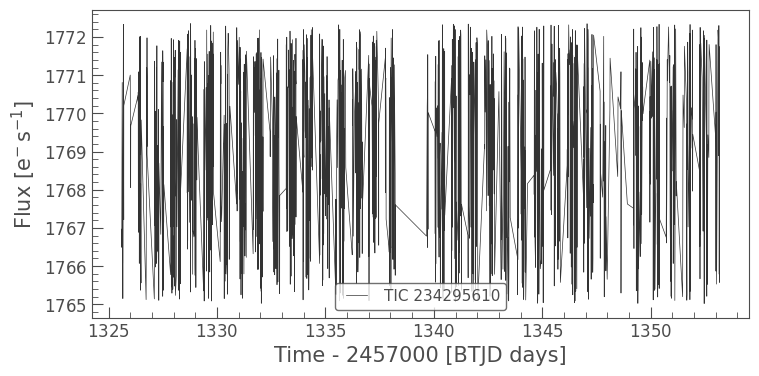

In [60]:
lc_clipped.plot()

# Rotation rates of a larger population
Now let's wrap the above in a function so that we can run it on a number of different objects.

In [67]:
def calc_rotation_rate(name):
    """
    Calculates the roation period of a star, assuming that rotation is the primary driver of the star's periodicity. 
    AS: come back to this?
    
    Inputs
    ------
        :name: name of star (str)
        
    Outputs
    -------
        :period_at_max_power: the dominant period in the light curve. [float]
    """
    
    
    # for all the selected targets, pull the available lightcurves using the lightkurve package
    sectors = [1, 2] # only consider the first few sectors
    lcs = []
    # for name in ticids:
    lc = search_lightcurve(target='TIC'+name, mission='TESS', sector=sectors, author='SPOC')
    lc = lc.download_all()[0]
    
    lc_interval = (lc.time.max() - lc.time.min()).value

    max_period = lc_interval/2
    
    pg = lc.normalize(unit='ppm').to_periodogram(maximum_period=max_period, minimum_period=min_period)

    period_at_max_power = pg.period_at_max_power
    
    return period_at_max_power

We can gather a population of stars using a flare catalog from a previous notebook ([Classifying stellar flares with stella](../../05-classify-with-ml)).

In [107]:
file_url = 'https://archive.stsci.edu/hlsps/hellouniverse/hellouniverse_stella_500.tar.gz'
file = tarfile.open(download_file(file_url, cache=True))
file.extractall('.')
file.close() # be sure to close files when you're finished with them!


With the file now downloaded, we can use the `astropy` package to simply read in the flare catalog file.

In [108]:
data_dir = './hellouniverse_stella_500/'
filename = 'Guenther_2020_flare_catalog.txt'

catalog = ascii.read(data_dir + filename)  
catalog

TIC,Outbst,Flare,tpeak,e_tpeak,E_tpeak,Amp,e_Amp,E_Amp,FWHMdt,e_FWHMdt,E_FWHMdt,Ebol,e_Ebol,E_Ebol,MCME,e_MCME,E_MCME
int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
2760232,1,1,2458357.381046,0.000863,0.000854,0.01475,0.00168,0.0017,0.01958,0.00307,0.00375,--,--,--,--,--,--
2760232,2,1,2458357.843604,0.001059,0.001026,0.01389,0.00162,0.00175,0.01612,0.00338,0.00394,--,--,--,--,--,--
2760232,3,1,2458359.79077,2.6e-05,2.6e-05,0.28258,0.00817,0.00949,0.00196,0.00017,0.00017,--,--,--,--,--,--
2760232,3,2,2458359.793415,0.000195,0.000195,0.04634,0.00589,0.00598,0.0061,0.00063,0.00062,--,--,--,--,--,--
2760232,3,3,2458359.816881,0.001735,0.001565,0.01665,0.00185,0.00155,0.05816,0.0092,0.00928,--,--,--,--,--,--
2760232,3,4,2458359.876649,0.000255,0.000404,0.01459,0.00396,0.00433,0.00265,0.00096,0.00233,--,--,--,--,--,--
2760232,5,1,2458360.659582,0.000143,0.00015,0.03723,0.00206,0.00224,0.00456,0.00038,0.00041,--,--,--,--,--,--
2760232,7,1,2458368.775507,6.5e-05,5.5e-05,0.13041,0.01312,0.01632,0.00156,0.00033,0.00033,--,--,--,--,--,--
2760232,7,2,2458368.781088,0.000302,0.000407,0.06287,0.01261,0.00799,0.00837,0.0011,0.00117,--,--,--,--,--,--


We're just interested in the stars themselves, which we can access with the following syntax:

In [109]:
stars = catalog['TIC'].data
stars

array([  2760232,   2760232,   2760232, ..., 471015484, 471015484,
       471015484])

Now, we apply this to the population. The whole population is quite large — if we take every 200th star, then the calculation will only take less than a couple of minutes.

In [125]:
rot_rates = []
for star in tqdm(stars[::200]):
    rot_rate = calc_rotation_rate(str(star))
    
    rot_rates += [rot_rate]

 27%|██▋       | 12/44 [00:05<00:14,  2.27it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
 36%|███▋      | 16/44 [00:06<00:11,  2.40it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
 45%|████▌     | 20/44 [00:08<00:09,  2.48it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
 61%|██████▏   | 27/44 [00:11<00:08,  2.02it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
 73%

We can use a histogram to get a sense of how the periods are distributed.

Text(0, 0.5, 'Count')

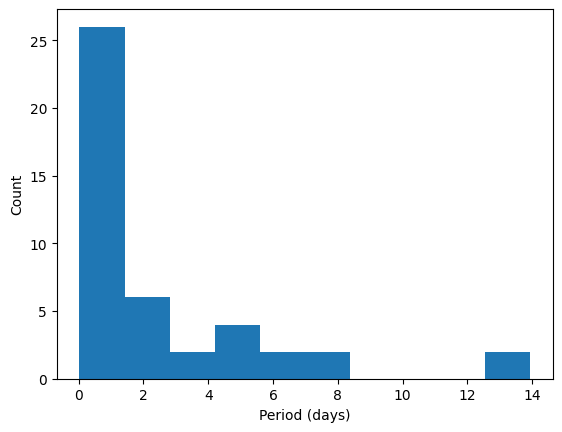

In [126]:
plt.hist(rot_rates)
plt.xlabel('Period (days)')
plt.ylabel('Count')

[AS:Describe this. Broad distribution of days. etc.]

# Assessing flares for this population
In a previous notebook, we trained a convolutional neural network (CNN) to classify stellar flares using the `stella` package (<a href="https://joss.theoj.org/papers/10.21105/joss.02347.pdf">Feinstein et al. 2020</a>). Now, we'll use the code and intuition developed in that notebook to answer the following question: Does a star's rotation rate affect its flaring rate?

In [ ]:
ds = stella.FlareDataSet(fn_dir=data_dir,
                         catalog=data_dir+filename) # using the same catalog as above

In [ ]:
# remove lightcurves with NaNs from training, test and validation data
def remove_nans(input_data):
    '''Determine indices of files without NaNs'''

    idx = []
    for k in range(np.shape(input_data)[0]):
        if len(input_data[k, :, :][np.isnan(input_data[k, :, :])]) == 0:
            idx.append(k)
    # AS: how do we want to talk about functions? assume that people know how they work for the intermediate notebooks?
    return idx


# find indices in train, test and validation sets without NaNs
idx_train = remove_nans(ds.train_data)
idx_test = remove_nans(ds.test_data)
idx_val = remove_nans(ds.val_data)

ds.train_data = ds.train_data[idx_train]
ds.train_labels = ds.train_labels[idx_train]

ds.test_data = ds.test_data[idx_test]
ds.test_labels = ds.test_labels[idx_test]

ds.val_data = ds.val_data[idx_val]
ds.val_labels = ds.val_labels[idx_val]


In [ ]:
# first, we load the mode.
cnn_file = 'initial_flare_model_small_dataset.h5' #AS: ask about where the files are from previous notebooks!
model = keras.models.load_model(cnn_file)

In [ ]:
# set up the ConvNN object.
cnn_stella = stella.ConvNN(output_dir=data_dir, ds=ds)

Next, let's check that our classifier is working correctly. To do so, we can just apply it to the first light curve we assessed above.

In [ ]:
cnn_stella.predict(cnn_file, times=lc.time.value, fluxes=lc.flux, errs=lc.flux_err)

In [ ]:
# cnn_stella.predict_flux[0]
fig, ax= plt.subplots()
im  = ax.scatter(cnn_stella.predict_time[0], cnn_stella.predict_flux[0], c=cnn_stella.predictions[0], s=1. )
plt.xlabel('Time (d)')
plt.ylabel('Flux') # AS: check units
plt.colorbar(im, label='Flare probability')
plt.show()


This seems to make sense. The "peakiest" parts of the light curves are labeled as flares by our classifier at high probability. To further verify this, we can zoom in and pick out some of the flare morphologgy.

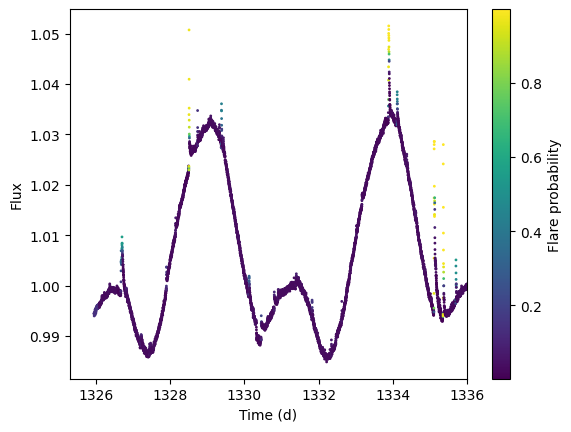

In [134]:
# cnn_stella.predict_flux[0]
fig, ax= plt.subplots()
im  = ax.scatter(cnn_stella.predict_time[0], cnn_stella.predict_flux[0], c=cnn_stella.predictions[0], s=1. )
plt.xlabel('Time (d)')
plt.xlim(lc.time.min().value, 1336)
plt.ylabel('Flux') # AS: check units
plt.colorbar(im, label='Flare probability')
plt.show()

We see a sharp increase in the flux followed by a slower fall — an example of classic flare morphology (e.g., <a href=https://iopscience.iop.org/article/10.3847/1538-3881/ac6fe6/meta>Mendoza et al. 2022</a>). Looks like the classifier that's working!

  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 1s 2ms/step


100%|██████████| 1/1 [00:03<00:00,  3.07s/it]


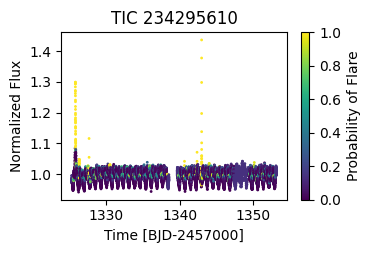

In [112]:
# if len(lc)>0: lc = lc[0]

# predict the flare probability light cuvey for the input data using `stella` 
# (which applies the necessary pre-processing to the data for input to the CNN)
fig = plt.figure(0, [8, 10])
i = 0

cnn_stella.predict(cnn_file, times=lc.time.value, fluxes=lc.flux, errs=lc.flux_err)

ax = fig.add_subplot(4,2,i+1)
im = ax.scatter(cnn_stella.predict_time[0], cnn_stella.predict_flux[0], c=cnn_stella.predictions[0], s=1. )

plt.colorbar(im, ax=ax, label='Probability of Flare')
ax.set_xlabel('Time [BJD-2457000]')
ax.set_ylabel('Normalized Flux')
ax.set_title('TIC {}'.format(lc.targetid));

How do we next assess the flare *rate*, now that we've identified flares in our light curve? The simplest thing to do here (and the thing we will start with) is to calculate what fraction of the time is spent flaring. Whlie this may overemphasize the presence of large / long flares, this metric is a good starting point.

In [113]:
flare_cutoff = 0.5 # the minimum value above which the CNN classifies a flare

total_length = len(cnn_stella.predictions[0])
flaring_length = len(cnn_stella.predictions[0][cnn_stella.predictions[0] > flare_cutoff])
frac_flaring = flaring_length/total_length

Text(0, 0.5, 'Period at max power (d)')

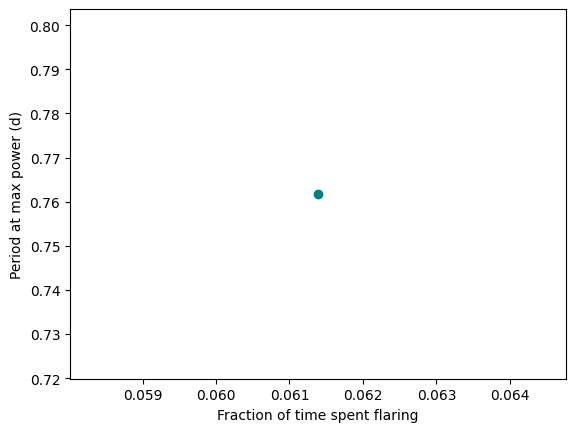

In [114]:
plt.scatter(frac_flaring, pg.period_at_max_power, color='teal')

plt.xlabel('Fraction of time spent flaring')
plt.ylabel('Period at max power (d)')

That's a single data point! The next step is to do this for the whole  population.

In [115]:
def calc_flare_rate(name):
    sectors = [1, 2] # only consider the first few sectors
    lcs = []
    # for name in ticids:
    lc = search_lightcurve(target='TIC'+name, mission='TESS', sector=sectors, author='SPOC')
    lc = lc.download_all()[0]
    
    cnn_stella.predict(cnn_file, times=lc.time.value, fluxes=lc.flux, errs=lc.flux_err)
    
    flare_rate = len(cnn_stella.predictions[0][cnn_stella.predictions[0] > 0.5])/len(cnn_stella.predictions[0])
    
    return flare_rate

Running the below for the whole population shouldn't take more than 3-4 minutes. We won't use the `tqdm` package this time, because it will produce a lot of output in combination with the `stella` predictions.

In [116]:
flare_rates = []
for star in stars[::200]:
    flare_rate = calc_flare_rate(str(star))
    
    flare_rates += [flare_rate]

  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 2s 2ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 1s 2ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

570/570 [==============================] - 1s 2ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 2s 3ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 1s 2ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 1s 2ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 1s 2ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

569/569 [==============================] - 1s 2ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 1s 2ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 1s 2ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 1s 2ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 1s 2ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 1s 2ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 1s 2ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 1s 2ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 1s 2ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 1s 2ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 1s 2ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 1s 2ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

537/537 [==============================] - 1s 2ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 1s 2ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 1s 2ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 2s 3ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

568/568 [==============================] - 1s 2ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 1s 2ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

520/520 [==============================] - 1s 2ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

541/541 [==============================] - 1s 2ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 1s 2ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 1s 2ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 1s 2ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 2s 3ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 1s 2ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 1s 2ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 1s 2ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 1s 2ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 1s 2ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 2s 3ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 1s 2ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 1s 2ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

570/570 [==============================] - 1s 2ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 1s 2ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 1s 2ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 1s 2ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

554/554 [==============================] - 1s 2ms/step


100%|██████████| 1/1 [00:02<00:00,  2.99s/it]


We first examine our flare rate alone.

Text(0, 0.5, 'Count')

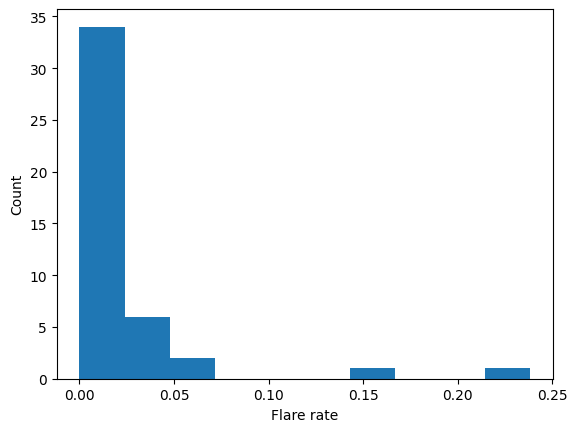

In [117]:
plt.hist(flare_rates)
plt.xlabel('Flare rate')
plt.ylabel('Count')


And now we compare the flare rate to the rotation rate.

In [128]:
rot_rates = [rot_rate.value for rot_rate in rot_rates]

Text(0, 0.5, 'Period at max power (d)')

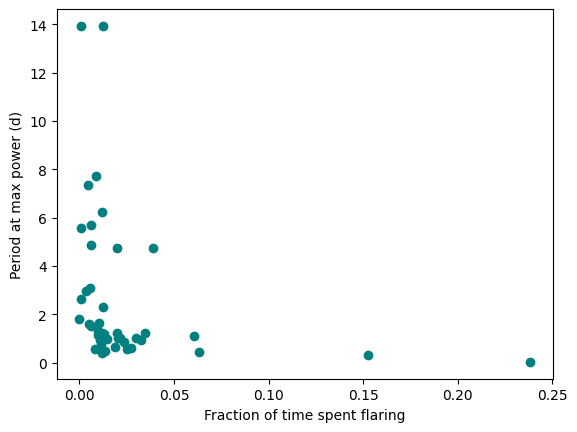

In [129]:
plt.scatter(flare_rates, rot_rates, color='teal')
            
plt.xlabel('Fraction of time spent flaring')
plt.ylabel('Period at max power (d)')

In [130]:
# AS: mask out points on the edges because they're likely artificial?

In [131]:
len(flare_rates)

44

In [132]:
len(rot_rates)

44

Now...fit some kind of line? Is there any structure?